<a href="https://colab.research.google.com/github/edquestofficial/gen-ai-case-study/blob/main/research/03_llamaindex/workflow/LLaMA_Index_Workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies

In [1]:
!pip install llama-index-core
!pip install llama-index-utils-workflow

!pip install llama-index-llms-openai
!pip install nest_asyncio

!pip install google-generativeai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.1 MB/s eta 0:00:00


# 1. Basic Workflow


## Required Imports

In [2]:
from llama_index.core.workflow import (
    StartEvent,
    StopEvent,
    Workflow,
    step,
)

## Single Step Workflow

In [8]:
class BasicWorkflow(Workflow):
    @step
    async def my_step(self, ev: StartEvent) -> StopEvent:
        # do something here
        return StopEvent(result="Hello, world!")


w = BasicWorkflow(timeout=10, verbose=False)
result = await w.run()
print(result)

Hello, world!


## Visualizing Workflow

In [9]:
from llama_index.utils.workflow import draw_all_possible_flows

draw_all_possible_flows(BasicWorkflow, filename="basic_workflow1.html")

<class 'NoneType'>
<class 'llama_index.core.workflow.events.StopEvent'>
basic_workflow1.html


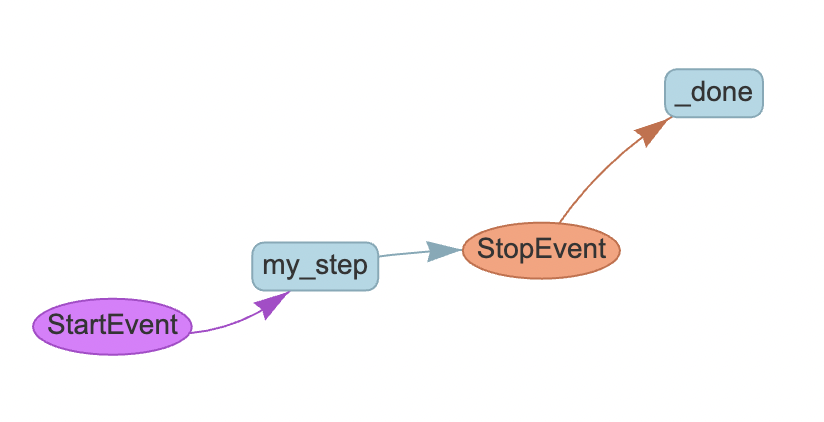

# 2. Branches

In [14]:
class BranchA1Event(Event):
    payload: str


class BranchA2Event(Event):
    payload: str


class BranchB1Event(Event):
    payload: str


class BranchB2Event(Event):
    payload: str


class BranchWorkflow(Workflow):
    @step
    async def start(self, ev: StartEvent) -> BranchA1Event | BranchB1Event:
        if random.randint(0, 1) == 0:
            print("Go to branch A")
            return BranchA1Event(payload="Branch A")
        else:
            print("Go to branch B")
            return BranchB1Event(payload="Branch B")

    @step
    async def step_a1(self, ev: BranchA1Event) -> BranchA2Event:
        print(ev.payload)
        return BranchA2Event(payload=ev.payload)

    @step
    async def step_b1(self, ev: BranchB1Event) -> BranchB2Event:
        print(ev.payload)
        return BranchB2Event(payload=ev.payload)

    @step
    async def step_a2(self, ev: BranchA2Event) -> StopEvent:
        print(ev.payload)
        return StopEvent(result="Branch A complete.")

    @step
    async def step_b2(self, ev: BranchB2Event) -> StopEvent:
        print(ev.payload)
        return StopEvent(result="Branch B complete.")




In [15]:
w = BranchWorkflow(timeout=10, verbose=False)
result = await w.run()
print(result)

Go to branch A
Branch A
Branch A
Branch A complete.


In [18]:
w = BranchWorkflow(timeout=10, verbose=False)
result = await w.run()
print(result)

Go to branch B
Branch B
Branch B
Branch B complete.


In [13]:
from llama_index.utils.workflow import draw_all_possible_flows

draw_all_possible_flows(BranchWorkflow, filename="branch_workflow.html")

<class 'NoneType'>
<class '__main__.BranchA1Event'>
<class '__main__.BranchB1Event'>
<class '__main__.BranchA2Event'>
<class 'llama_index.core.workflow.events.StopEvent'>
<class '__main__.BranchB2Event'>
<class 'llama_index.core.workflow.events.StopEvent'>
branch_workflow.html


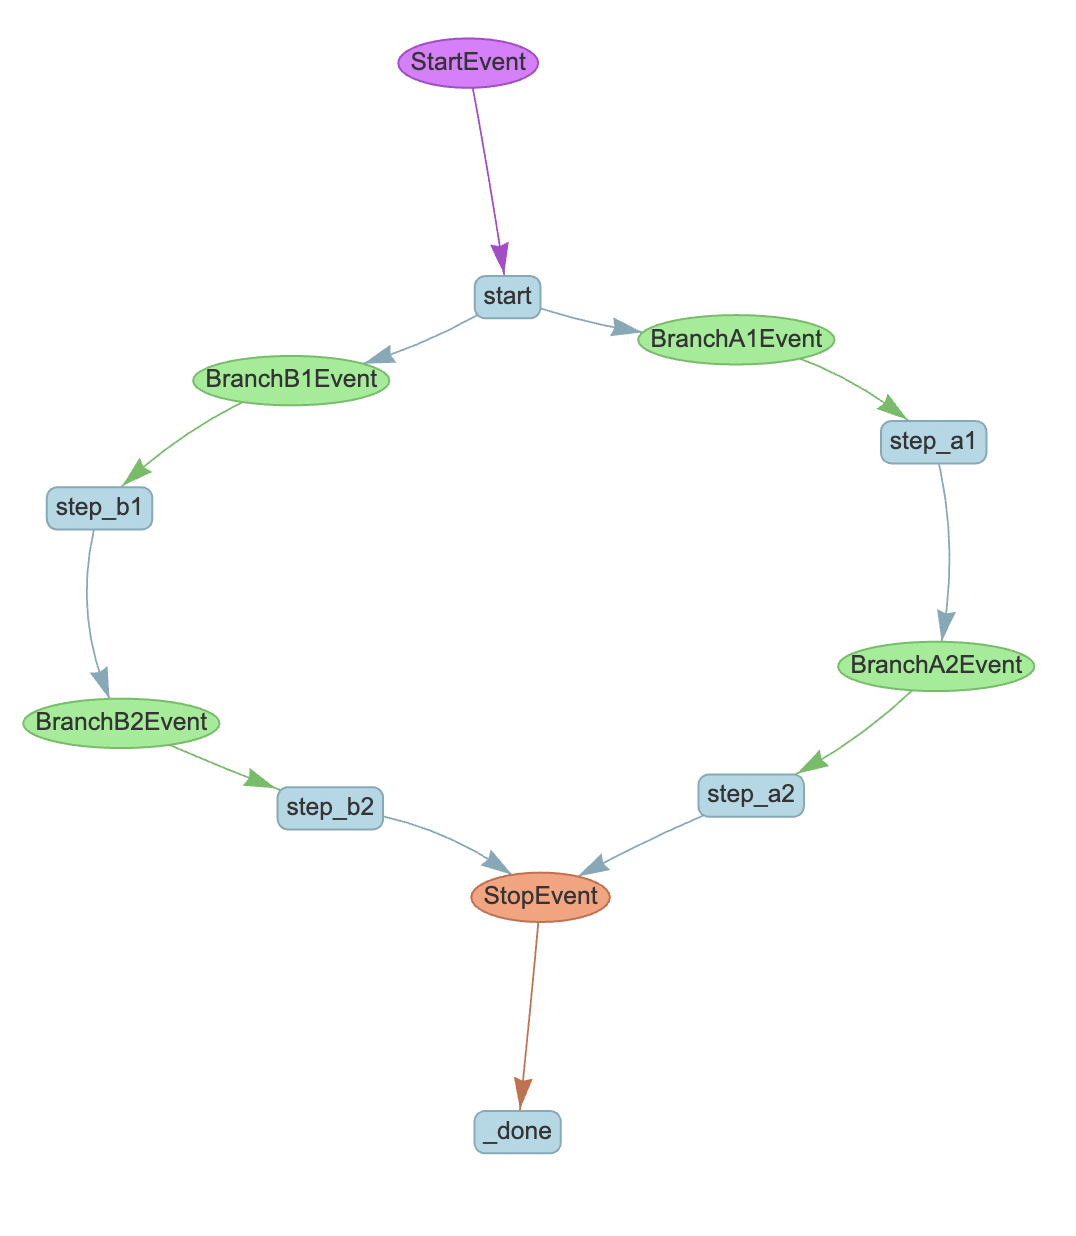

# 3. Loops

In [15]:
from llama_index.core.workflow import (
    StartEvent,
    StopEvent,
    Workflow,
    step,
    Event
)
import random

class LoopEvent(Event):
    loop_output: str

class LoopWorkflow(Workflow):
  @step
  async def step_one(self, ev: StartEvent | LoopEvent) -> StopEvent | LoopEvent:
    if random.randint(0, 1) == 0:
      print("Bad thing happened")
      return LoopEvent(loop_output="Back to step one.")
    else:
      print("Good thing happened")
      return StopEvent(result="Stop Event complete.")

In [18]:
w = LoopWorkflow(timeout=10, verbose=False)
result = await w.run()
print(result)

Bad thing happened
Bad thing happened
Bad thing happened
Bad thing happened
Good thing happened
Stop Event complete.


In [16]:
w = LoopWorkflow(timeout=10, verbose=False)
result = await w.run()
print(result)

Bad thing happened
Good thing happened
Stop Event complete.


In [17]:
from llama_index.utils.workflow import draw_all_possible_flows

draw_all_possible_flows(LoopWorkflow, filename="loop_workflow.html")

<class 'NoneType'>
<class 'llama_index.core.workflow.events.StopEvent'>
<class '__main__.LoopEvent'>
loop_workflow.html


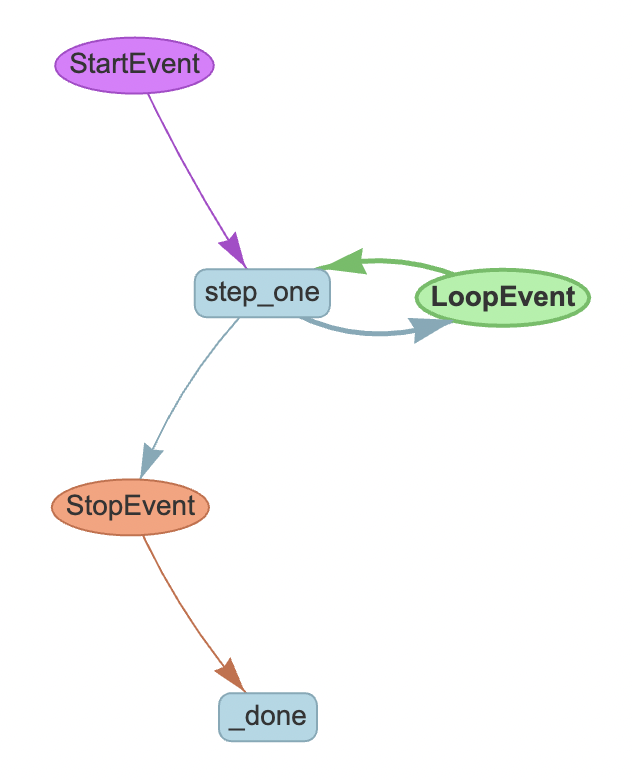

# 4. Maintaining State

In [10]:
from llama_index.core.workflow import (
    StartEvent,
    StopEvent,
    Workflow,
    step,
    Event,
    Context,
)

In [11]:
class SetupEvent(Event):
    query: str


class StepTwoEvent(Event):
    query: str


class StatefulFlow(Workflow):
    @step
    async def start(
        self, ctx: Context, ev: StartEvent
    ) -> SetupEvent | StepTwoEvent:
        db = await ctx.get("some_database", default=None)
        print("DB is ", db)
        if db is None:
            print("Need to load data")
            return SetupEvent(query=ev.query)

        # do something with the query
        print("Start is called --------")
        return StepTwoEvent(query=ev.query)

    @step
    async def setup(self, ctx: Context, ev: SetupEvent) -> StartEvent:
        # load data
        await ctx.set("some_database", [1, 2, 3])
        query = ev.query
        print("query ------ ", query)
        return StartEvent(query=ev.query)

    @step
    async def step_two(self, ctx: Context, ev: StepTwoEvent) -> StopEvent:
        # do something with the data
        print("Data is ", await ctx.get("some_database"))
        db = await ctx.get("some_database", default=None)
        print(db[1])
        return StopEvent(result=db[1])

    @step
    async def step_two(self, ctx: Context, ev: StepTwoEvent) -> StopEvent:
        # do something with the data
        print("Data is ", await ctx.get("some_database"))
        db = await ctx.get("some_database")

        return StopEvent(result=db[1])


In [12]:
w = StatefulFlow(timeout=10, verbose=False)
result = await w.run(query="Some query")
print(result)

DB is  None
Need to load data
query ------  Some query
DB is  [1, 2, 3]
Start is called --------
Data is  [1, 2, 3]
2


In [13]:
from llama_index.utils.workflow import draw_all_possible_flows

draw_all_possible_flows(StatefulFlow, filename="stateful_workflow1.html")

<class 'NoneType'>
<class 'llama_index.core.workflow.events.StartEvent'>
<class '__main__.SetupEvent'>
<class '__main__.StepTwoEvent'>
<class 'llama_index.core.workflow.events.StopEvent'>
stateful_workflow1.html


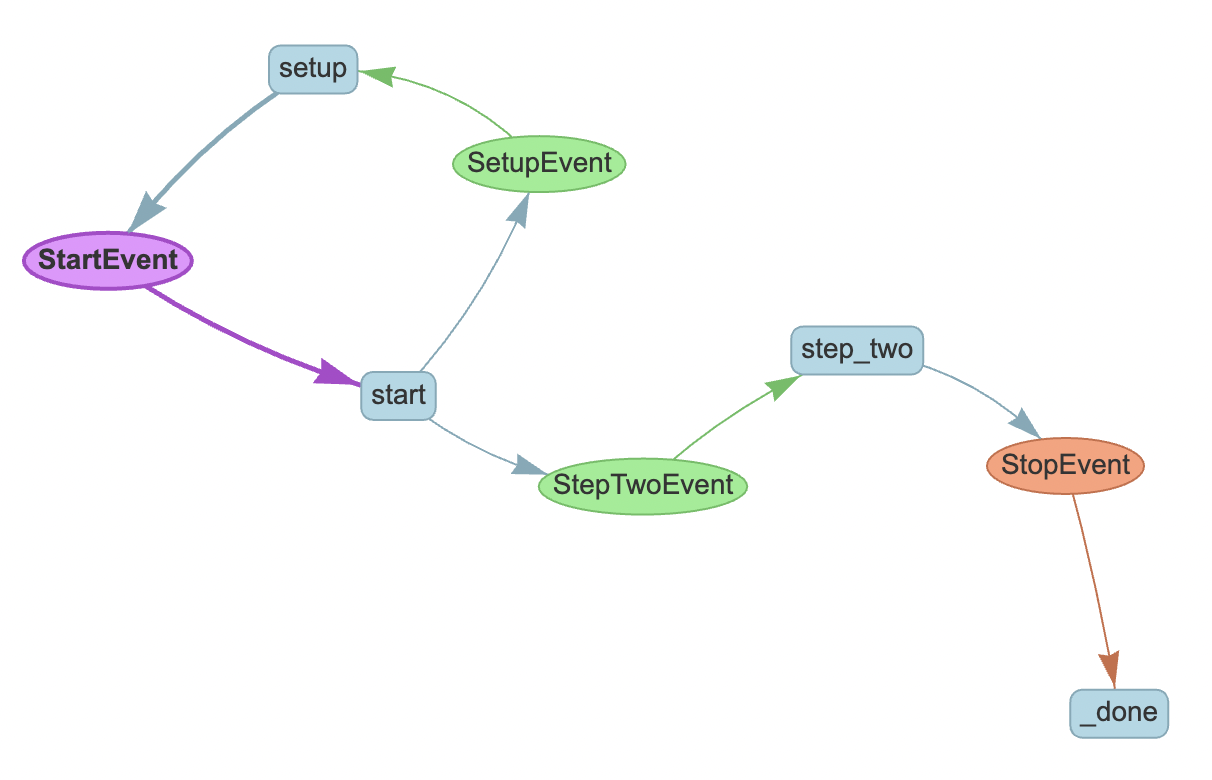

# 5. Streaming events

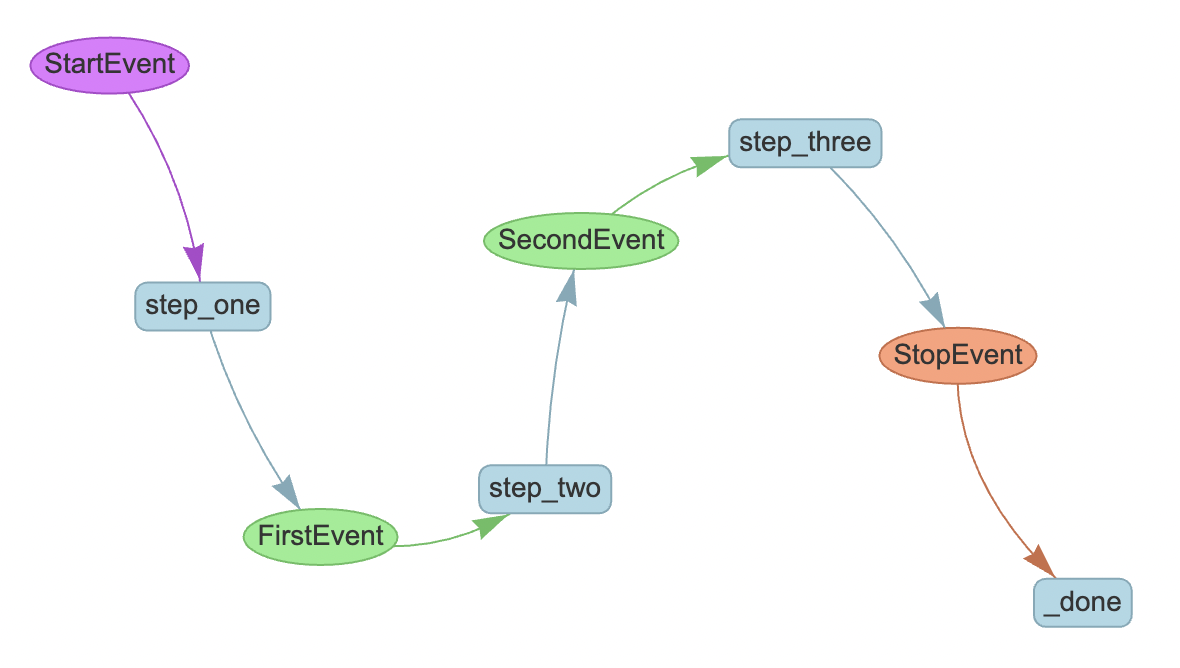

## By using OPENAI

In [45]:
import os

os.environ["OPENAI_API_KEY"] = "OPENAI_API_KEY"

In [47]:
from llama_index.core.workflow import (
    StartEvent,
    StopEvent,
    Workflow,
    step,
    Event,
    Context,
)
import asyncio
from llama_index.llms.openai import OpenAI
from llama_index.utils.workflow import draw_all_possible_flows

In [48]:
class FirstEvent(Event):
    first_output: str


class SecondEvent(Event):
    second_output: str
    response: str


class ProgressEvent(Event):
    msg: str

In [49]:
class MyWorkflow(Workflow):
    @step
    async def step_one(self, ctx: Context, ev: StartEvent) -> FirstEvent:
        ctx.write_event_to_stream(ProgressEvent(msg="Step one is happening"))
        return FirstEvent(first_output="First step complete.")

    @step
    async def step_two(self, ctx: Context, ev: FirstEvent) -> SecondEvent:
        llm = OpenAI(model="gpt-4o-mini")
        generator = await llm.astream_complete(
            "Please give me the first 3 paragraphs of Moby Dick, a book in the public domain."
        )
        async for response in generator:
            # Allow the workflow to stream this piece of response
            ctx.write_event_to_stream(ProgressEvent(msg=response.delta))
        return SecondEvent(
            second_output="Second step complete, full response attached",
            response=str(response),
        )

    @step
    async def step_three(self, ctx: Context, ev: SecondEvent) -> StopEvent:
        ctx.write_event_to_stream(ProgressEvent(msg="Step three is happening"))
        return StopEvent(result="Workflow complete.")

In [50]:
import asyncio

async def main():
    w = MyWorkflow(timeout=30, verbose=True)
    handler = w.run(first_input="Start the workflow.")

    async for ev in handler.stream_events():
        if isinstance(ev, ProgressEvent):
            print(ev.msg)

    final_result = await handler
    print("Final result", final_result)

    draw_all_possible_flows(MyWorkflow, filename="streaming_workflow.html")

In [53]:
import nest_asyncio
import asyncio

# Apply nest_asyncio
nest_asyncio.apply()

await main()

/usr/lib/python3.10/asyncio/base_events.py:773: RuntimeWarning: coroutine 'main' was never awaited
  handle = events.Handle(callback, args, self, context)


Running step step_one
Step step_one produced event FirstEvent
Running step step_two
Step one is happening

Sure
!
 Here
 are
 the
 first
 three
 paragraphs
 of
 "
M
oby
-D
ick
"
 by
 Herman
 Mel
ville
:


---


Call
 me
 Ish
mael
.
 Some
 years
 ago
—
never
 mind
 how
 long
 precisely
—I
 had
 little
 or
 no
 money
 in
 my
 purse
,
 and
 nothing
 particular
 to
 interest
 me
 on
 shore
.
 So
 whenever
 I
 find
 myself
 growing
 grim
 about
 the
 mouth
;
 whenever
 it
 is
 a
 damp
,
 dr
izzly
 November
 in
 my
 soul
;
 whenever
 I
 find
 myself
 invol
unt
arily
 pa
using
 before
 coffin
 warehouses
,
 and
 bringing
 up
 the
 rear
 of
 every
 funeral
 I
 meet
;
 and
 especially
 whenever
 my
 hy
pos
 get
 such
 an
 upper
 hand
 of
 me
,
 that
 it
 requires
 a
 strong
 moral
 principle
 to
 prevent
 me
 from
 deliberately
 stepping
 into
 the
 street
,
 and
 method
ically
 knocking
 people
’s
 hats
 off
—
then
,
 I
 account
 it
 high
 time
 to
 get
 to
 sea
 as
 soon
 as
 I
 can
.
 This
 

## By using Gemini

In [63]:
# Import Generative AI Module
import google.generativeai as genai

# Configure api_key
genai.configure(api_key="AIzaSyAonLEV699aBCvzdDgY8G2Pwxkt0")

In [64]:
# Define Model Instance
model = genai.GenerativeModel('gemini-pro')

# Define prompt
prompt = 'Who is the prime minister of India?'

# Execute Prompt
response = model.generate_content(prompt)
print(response.text)

Narendra Modi


In [68]:
import google.generativeai as llm

# Configure your API key if necessary

async def main():
  # Create the prompt for completion
  prompt = """
  You are an assistant trained to answer questions about machine learning. Please provide concise, helpful, and accurate answers.
  Question: Explain the concept of overfitting in machine learning.
  """

  # Call astream_complete for asynchronous streaming
  # response = llm.astream_complete(prompt)
  response = model.generate_content(prompt)
  print("response ---- ", response.text)

  # Collect and print responses as they stream
  # async for message in response:
  #     print(message['content'])

await main()

response ----  **Overfitting in Machine Learning:**

Overfitting occurs when a machine learning model performs well on training data but poorly on unseen data. This happens when the model learns the specific details and patterns of the training data too closely, instead of generalizing to the larger population.

**Causes of Overfitting:**

* **High model complexity:** Models with a large number of parameters or features can fit the training data too closely.
* **Small training data size:** The model cannot learn general patterns if the training data is not representative of the population.
* **High noise in the training data:** The model may overfit to random fluctuations in the data instead of meaningful patterns.

**Consequences of Overfitting:**

* Poor performance on unseen data
* Unreliable predictions
* Difficulty in interpreting the model's behavior

**Preventing Overfitting:**

* **Regularization techniques:** Penalize the model for complex solutions, forcing it to generalize.


### Generate Response in Streaming Format
 - model.generate_content(prompt, <b>`stream=True`</b>)

In [65]:
# Execute Prompt in Streaming format
response = model.generate_content(prompt, stream=True)

for chunk in response:
    print(chunk.text)
    print("_"*80)

Narendra Modi
________________________________________________________________________________


In [69]:
async def main():
  # Create the prompt for completion
  prompt = """
  You are an assistant trained to answer questions about machine learning. Please provide concise, helpful, and accurate answers.
  Question: Explain the concept of overfitting in machine learning.
  """

  # Call astream_complete for asynchronous streaming
  # response = llm.astream_complete(prompt)
  response = model.generate_content(prompt, stream=True)
  # print("response ---- ", response.text)

  for chunk in response:
    print(chunk.text)
    print("_"*80)

await main()

Overfitting is a phenomenon in machine learning where a model performs exceptionally well on the
________________________________________________________________________________
 training data but poorly on unseen data. This occurs when the model is too complex and learns the idiosyncrasies of the training data instead of capturing the underlying patterns
________________________________________________________________________________
. As a result, the model fails to generalize well to new data.
________________________________________________________________________________


# 6. Concurrent execution of workflows

## Emitting multiple events

In [51]:
from llama_index.core.workflow import (
    step,
    Context,
    Workflow,
    Event,
    StartEvent,
    StopEvent
)
import asyncio
import random

# Defining Event Class
class StepTwoEvent(Event):
    query: str

class ParallelFlow(Workflow):
    @step
    async def start(self, ctx: Context, ev: StartEvent) -> StepTwoEvent:
        ctx.send_event(StepTwoEvent(query="Query 1"))
        ctx.send_event(StepTwoEvent(query="Query 2"))
        ctx.send_event(StepTwoEvent(query="Query 3"))
        ctx.send_event(StepTwoEvent(query="Query 4"))
        ctx.send_event(StepTwoEvent(query="Query 5"))
        ctx.send_event(StepTwoEvent(query="Query 6"))
        ctx.send_event(StepTwoEvent(query="Query 7"))

    # Workflow to run up to 4 instances of this step concurrently
    @step(num_workers=4)
    async def step_two(self, ctx: Context, ev: StepTwoEvent) -> StopEvent:
        print("Running slow query ", ev.query)
        await asyncio.sleep(random.randint(1, 5))

        return StopEvent(result=ev.query)

In [55]:
w = ParallelFlow(timeout=10, verbose=False)
result = await w.run()
print(result)

Running slow query  Query 1
Running slow query  Query 2
Running slow query  Query 3
Running slow query  Query 4
Running slow query  Query 5
Running slow query  Query 6
Query 4


In [38]:
from llama_index.utils.workflow import draw_all_possible_flows

draw_all_possible_flows(ParallelFlow, filename="parallel_workflow.html")

<class 'NoneType'>
<class '__main__.StepTwoEvent'>
<class 'llama_index.core.workflow.events.StopEvent'>
parallel_workflow.html


## Concurrent WorkFlow

In [39]:
from llama_index.core.workflow import (
    step,
    Context,
    Workflow,
    Event,
    StartEvent,
    StopEvent
)
import asyncio
import random

class StepTwoEvent(Event):
    query: str

class StepThreeEvent(Event):
    result: str

class ConcurrentFlow(Workflow):
    @step
    async def start(self, ctx: Context, ev: StartEvent) -> StepTwoEvent:
        ctx.send_event(StepTwoEvent(query="Query 1"))
        ctx.send_event(StepTwoEvent(query="Query 2"))
        ctx.send_event(StepTwoEvent(query="Query 3"))

    @step(num_workers=4)
    async def step_two(self, ctx: Context, ev: StepTwoEvent) -> StepThreeEvent:
        print("Running query ", ev.query)
        await asyncio.sleep(random.randint(1, 5))
        return StepThreeEvent(result=ev.query)

    @step
    async def step_three(self, ctx: Context, ev: StepThreeEvent) -> StopEvent:
        # wait until we receive 3 events
        result = ctx.collect_events(ev, [StepThreeEvent] * 3)
        if result is None:
            return None

        # do something with all 3 results together
        print(result)
        return StopEvent(result="Done")

In [40]:
w = ConcurrentFlow(timeout=10, verbose=False)
result = await w.run()
print(result)

Running query  Query 1
Running query  Query 2
Running query  Query 3
[StepThreeEvent(result='Query 1'), StepThreeEvent(result='Query 2'), StepThreeEvent(result='Query 3')]
Done


In [41]:
from llama_index.utils.workflow import draw_all_possible_flows

draw_all_possible_flows(ConcurrentFlow, filename="concurrent_workflow.html")

<class 'NoneType'>
<class '__main__.StepTwoEvent'>
<class 'llama_index.core.workflow.events.StopEvent'>
<class '__main__.StepThreeEvent'>
concurrent_workflow.html


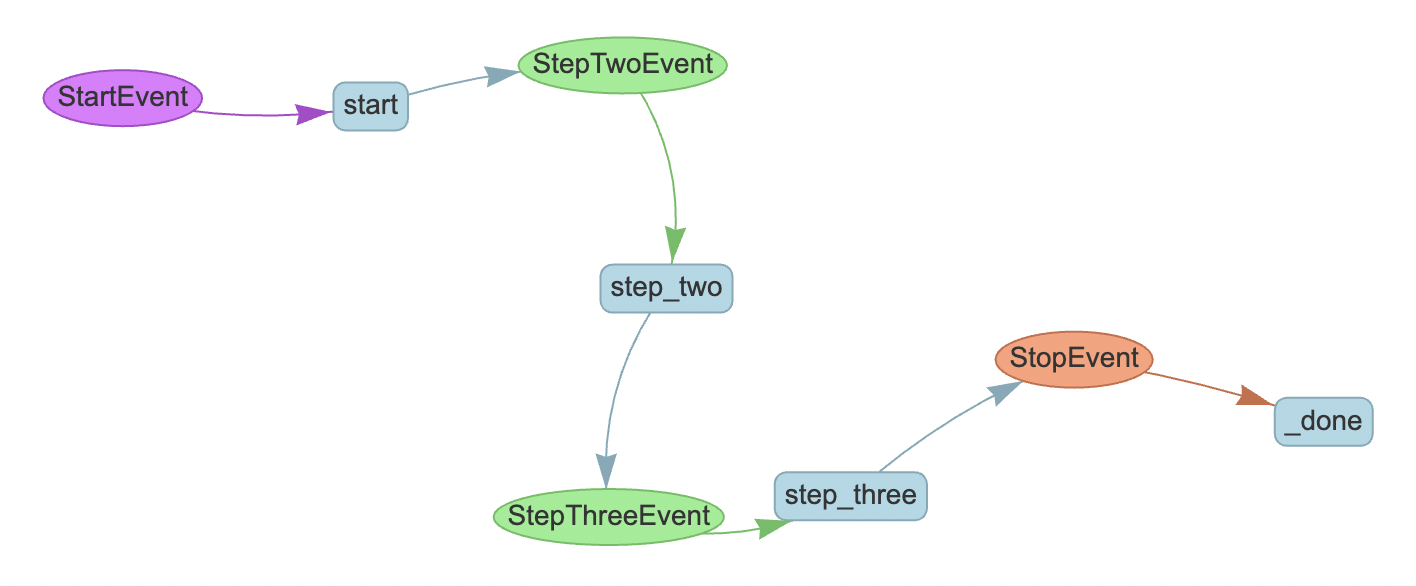

## Multiple event types

In [44]:
from llama_index.core.workflow import (
    step,
    Context,
    Workflow,
    Event,
    StartEvent,
    StopEvent
)

class StepAEvent(Event):
    query: str

class StepBEvent(Event):
    query: str

class StepCEvent(Event):
    query: str

class StepACompleteEvent(Event):
    result: str


class StepBCompleteEvent(Event):
    result: str


class StepCCompleteEvent(Event):
    result: str

class ConcurrentFlow1(Workflow):
    @step
    async def start(
        self, ctx: Context, ev: StartEvent
    ) -> StepAEvent | StepBEvent | StepCEvent:
        ctx.send_event(StepAEvent(query="Query 1"))
        ctx.send_event(StepBEvent(query="Query 2"))
        ctx.send_event(StepCEvent(query="Query 3"))

    @step
    async def step_a(self, ctx: Context, ev: StepAEvent) -> StepACompleteEvent:
        print("Doing something A-ish")
        return StepACompleteEvent(result=ev.query)

    @step
    async def step_b(self, ctx: Context, ev: StepBEvent) -> StepBCompleteEvent:
        print("Doing something B-ish")
        return StepBCompleteEvent(result=ev.query)

    @step
    async def step_c(self, ctx: Context, ev: StepCEvent) -> StepCCompleteEvent:
        print("Doing something C-ish")
        return StepCCompleteEvent(result=ev.query)

    @step
    async def step_three(
        self,
        ctx: Context,
        ev: StepACompleteEvent | StepBCompleteEvent | StepCCompleteEvent,
    ) -> StopEvent:
        print("Received event ", ev.result)

        # wait until we receive 3 events
        if (
            ctx.collect_events(
                ev,
                [StepCCompleteEvent, StepACompleteEvent, StepBCompleteEvent],
            )
            is None
        ):
            return None

        # do something with all 3 results together
        return StopEvent(result="Done")

In [45]:
w = ConcurrentFlow1(timeout=10, verbose=False)
result = await w.run()
print(result)

Doing something A-ish
Doing something B-ish
Doing something C-ish
Received event  Query 1
Received event  Query 2
Received event  Query 3
Done


In [46]:
from llama_index.utils.workflow import draw_all_possible_flows

draw_all_possible_flows(ConcurrentFlow1, filename="concurrent_workflow1.html")

<class 'NoneType'>
<class '__main__.StepAEvent'>
<class '__main__.StepBEvent'>
<class '__main__.StepCEvent'>
<class '__main__.StepACompleteEvent'>
<class '__main__.StepBCompleteEvent'>
<class '__main__.StepCCompleteEvent'>
<class 'llama_index.core.workflow.events.StopEvent'>
concurrent_workflow1.html


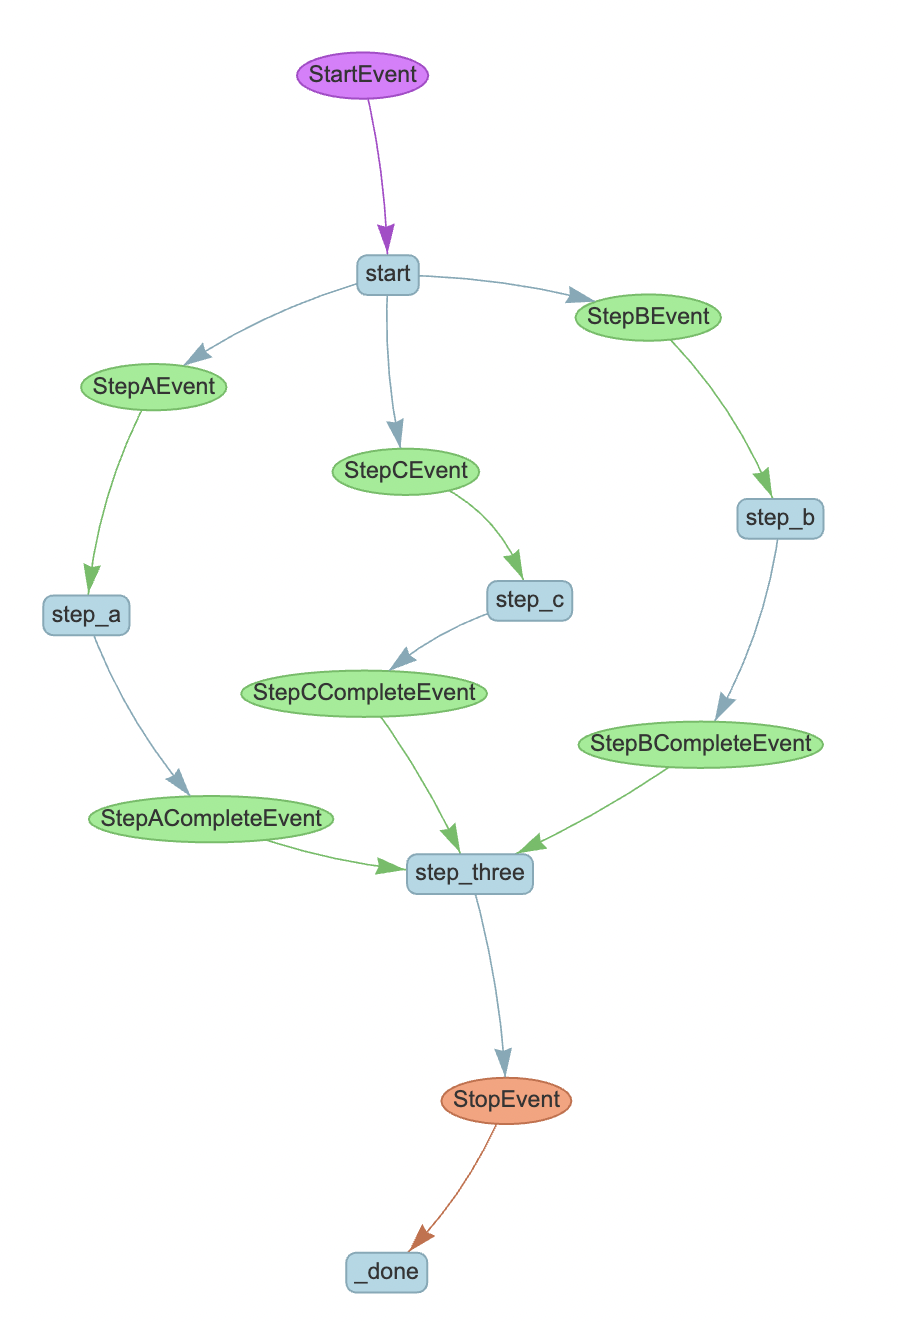

# 7. Subclassing workflows

let's say you have an agentic workflow that does some processing and then sends an email. You can subclass the workflow to add an extra step to send a text message as well.

Documentation: https://docs.llamaindex.ai/en/stable/understanding/workflows/subclass/

In [2]:
from llama_index.core.workflow import (
    StartEvent,
    StopEvent,
    Workflow,
    step,
    Event,
    Context,
)


class Step2Event(Event):
    query: str


class Step3Event(Event):
    query: str


class MainWorkflow(Workflow):
    @step
    async def start(self, ev: StartEvent) -> Step2Event:
        print("Starting up")
        return Step2Event(query=ev.query)

    @step
    async def step_two(self, ev: Step2Event) -> Step3Event:
        print("Sending an email")
        return Step3Event(query=ev.query)

    @step
    async def step_three(self, ev: Step3Event) -> StopEvent:
        print("Finishing up")
        return StopEvent(result=ev.query)

In [3]:
w = MainWorkflow(timeout=10, verbose=False)
result = await w.run(query="Initial query")
print(result)

Starting up
Sending an email
Finishing up
Initial query


In [4]:
class Step2BEvent(Event):
    query: str


class CustomWorkflow(MainWorkflow):
    @step
    async def step_two(self, ev: Step2Event) -> Step2BEvent:
        print("Sending an email")
        return Step2BEvent(query=ev.query)

    @step
    async def step_two_b(self, ev: Step2BEvent) -> Step3Event:
        print("Also sending a text message")
        return Step3Event(query=ev.query)

In [5]:
w = CustomWorkflow(timeout=10, verbose=False)
result = await w.run(query="Initial query")
print(result)

Starting up
Sending an email
Also sending a text message
Finishing up
Initial query


In [6]:
from llama_index.utils.workflow import draw_all_possible_flows

draw_all_possible_flows(CustomWorkflow, filename="custom_workflow.html")

<class 'NoneType'>
<class '__main__.Step2Event'>
<class 'llama_index.core.workflow.events.StopEvent'>
<class '__main__.Step2BEvent'>
<class '__main__.Step3Event'>
custom_workflow.html


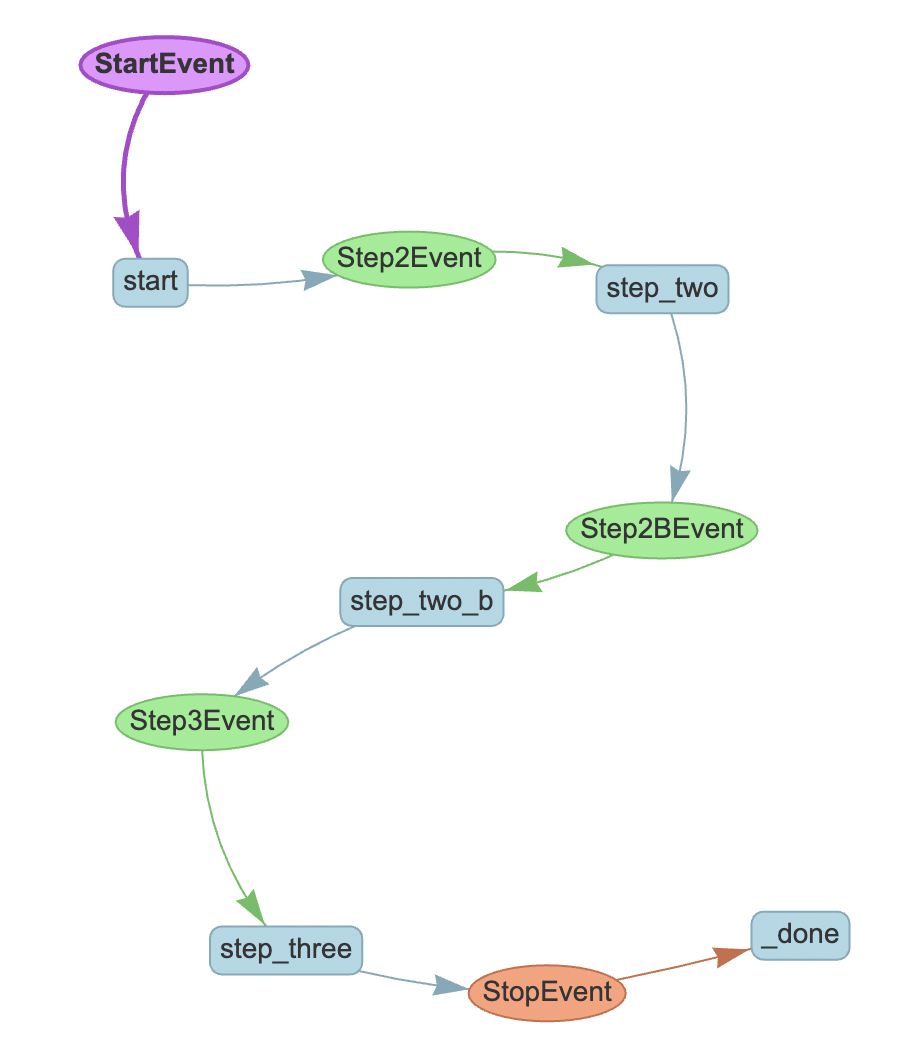

In [7]:
from llama_index.utils.workflow import draw_most_recent_execution

draw_most_recent_execution(w, filename="custom_workflow1.html")

custom_workflow1.html


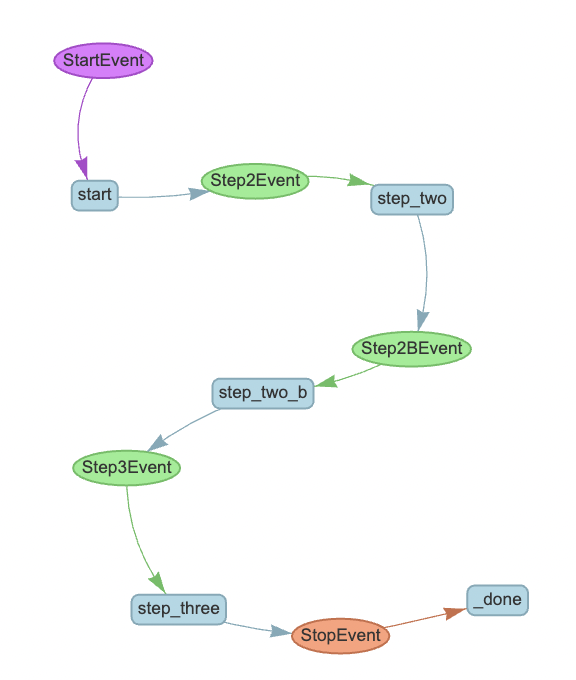

# 8. Nested workflows

# Final Workflow

In [53]:
from llama_index.core.workflow import (
    StartEvent,
    StopEvent,
    Workflow,
    step,
    Event
)
import random

class JudgeEvent(Event):
    payload: str
    query: str

class BadQueryEvent(Event):
    payload: str

class GoodQueryEvent(Event):
    payload: str

class NaiveRAGEvent(Event):
    query: str

class HighTopKEvent(Event):
    query: str

class RerankEvent(Event):
    query: str

class ResponseEvent(Event):
    payload: str


class FinalWorkflow(Workflow):

    @step
    async def judge_query(self, ev: StartEvent | JudgeEvent ) -> BadQueryEvent | NaiveRAGEvent | HighTopKEvent | RerankEvent:
        print("judge_query runs")
        if random.randint(0, 1) == 0:
            print("Go to BadQueryEvent")
            return BadQueryEvent(payload="Branch A")
        else:
            print("Go to GoodQueryEvent")
            self.send_event(NaiveRAGEvent(query="Naive Query"))
            self.send_event(HighTopKEvent(query="High Top K Query"))
            self.send_event(RerankEvent(query="Rerank Query"))

    @step
    async def improve_query(self, ev: BadQueryEvent) -> JudgeEvent:
        print("improve_query runs")
        print(ev.payload)
        return JudgeEvent(query=ev.payload)

    @step
    async def naive_rag(self, ev: NaiveRAGEvent) -> ResponseEvent:
        print("good_query runs")
        print(ev.query)
        return ResponseEvent(payload=ev.query)

    @step
    async def high_top_k(self, ev: HighTopKEvent) -> ResponseEvent:
        print("good_query runs")
        print(ev.query)
        return ResponseEvent(payload=ev.query)
    @step
    async def rerank(self, ev: RerankEvent) -> ResponseEvent:
        print("good_query runs")
        print(ev.query)
        return ResponseEvent(payload=ev.query)

    @step
    async def judge(self, ev: ResponseEvent) -> StopEvent:
        print("good_query runs")
        print(ev.payload)
        return StopEvent(result=ev.payload)


In [54]:
w = FinalWorkflow(timeout=10, verbose=False)
result = await w.run()
print(result)

judge_query runs
Go to GoodQueryEvent
good_query runs
Naive Query
good_query runs
Rerank Query
good_query runs
High Top K Query
good_query runs
Naive Query
good_query runs
Rerank Query
good_query runs
High Top K Query
High Top K Query


/usr/local/lib/python3.10/dist-packages/llama_index/core/workflow/workflow.py:316: UserWarning: Use a Context instance to send events from a step. Make sure your step method or function takes a parameter of type Context like `ctx: Context` and replace `self.send_event(...)` with `ctx.send_event(...)` in your code.
  warnings.warn(msg)


In [55]:
from llama_index.utils.workflow import draw_all_possible_flows

draw_all_possible_flows(FinalWorkflow, filename="final_workflow.html")

<class 'NoneType'>
<class '__main__.ResponseEvent'>
<class '__main__.JudgeEvent'>
<class 'llama_index.core.workflow.events.StopEvent'>
<class '__main__.BadQueryEvent'>
<class '__main__.NaiveRAGEvent'>
<class '__main__.HighTopKEvent'>
<class '__main__.RerankEvent'>
<class '__main__.ResponseEvent'>
<class '__main__.ResponseEvent'>
final_workflow.html
